In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [2]:
config = f"""
execution:
    exp_id: exp_009
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    1st_stage_oof: /kaggle/output/exp_005/oof.csv

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
train = pd.read_csv(CFG["dataset"]["1st_stage_oof"])
train = train.rename(columns={"oof": "last_oof"})
train.head()

,target,step,series_id,fold,last_oof
0,1,11.5,038441c925bb,2,0.998872
1,1,35.5,038441c925bb,2,0.998753
2,1,59.5,038441c925bb,2,0.991332
3,1,83.5,038441c925bb,2,0.990948
4,1,107.5,038441c925bb,2,0.990733


## 特徴生成

In [4]:
def generate_features(train: pd.DataFrame):
    features = Features()
    features.add_num_feature("last_oof")
    columns = ["last_oof"]

    # その人のその時刻での平均的な測定値
    train["step_norm"] = train["step"] % (60 * 60 * 24 // 5)
    gb = train.groupby("step_norm")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["last_oof_mean"] = train["step_norm"].map(gb["last_oof_mean"])
    features.add_num_features(gb.columns.tolist())
    columns += gb.columns.tolist()

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)
    columns += f_names

    # rolling
    dts = [-1000, -100, -50, -20, -10, -5, -2, -1, 1, 2, 5, 10, 20, 50, 100, 1000]
    for dt in dts:            
        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

In [5]:
def generate_features_wrapper(args):
    _, df = args
    return generate_features(df)

if CFG["execution"]["multiprocessing"]:
    group_list = list(train.groupby("series_id"))
    with Pool(30) as pool:
        dfs = list(tqdm(pool.imap(generate_features_wrapper, group_list), total=len(group_list)))
    train = pd.concat([df for df, _ in dfs])
    features = dfs[0][1]
else:
    dfs = []
    for _, df in tqdm(train.groupby("series_id")):
        df, features = generate_features(df)
        dfs.append(df)
    train = pd.concat(dfs)

100%|██████████| 277/277 [00:27<00:00,  9.99it/s]


## 学習

In [6]:
train.shape

(5331163, 201)

In [7]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.60693
[50]	eval-logloss:0.09188
[100]	eval-logloss:0.09246
[132]	eval-logloss:0.09382


 20%|██        | 1/5 [05:55<23:40, 355.03s/it]

== fold 1 ==
[0]	eval-logloss:0.60575
[50]	eval-logloss:0.07197
[100]	eval-logloss:0.07154
[113]	eval-logloss:0.07202


 40%|████      | 2/5 [10:57<16:12, 324.04s/it]

== fold 2 ==
[0]	eval-logloss:0.60662
[50]	eval-logloss:0.08833
[100]	eval-logloss:0.08948
[111]	eval-logloss:0.09020


 60%|██████    | 3/5 [15:53<10:22, 311.24s/it]

== fold 3 ==
[0]	eval-logloss:0.60713
[50]	eval-logloss:0.09214
[100]	eval-logloss:0.09270
[131]	eval-logloss:0.09465


 80%|████████  | 4/5 [21:33<05:22, 322.49s/it]

== fold 4 ==
[0]	eval-logloss:0.60731
[50]	eval-logloss:0.07869
[100]	eval-logloss:0.07690
[150]	eval-logloss:0.07649
[174]	eval-logloss:0.07694


100%|██████████| 5/5 [28:52<00:00, 346.56s/it]


In [8]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

## 予測値の作成

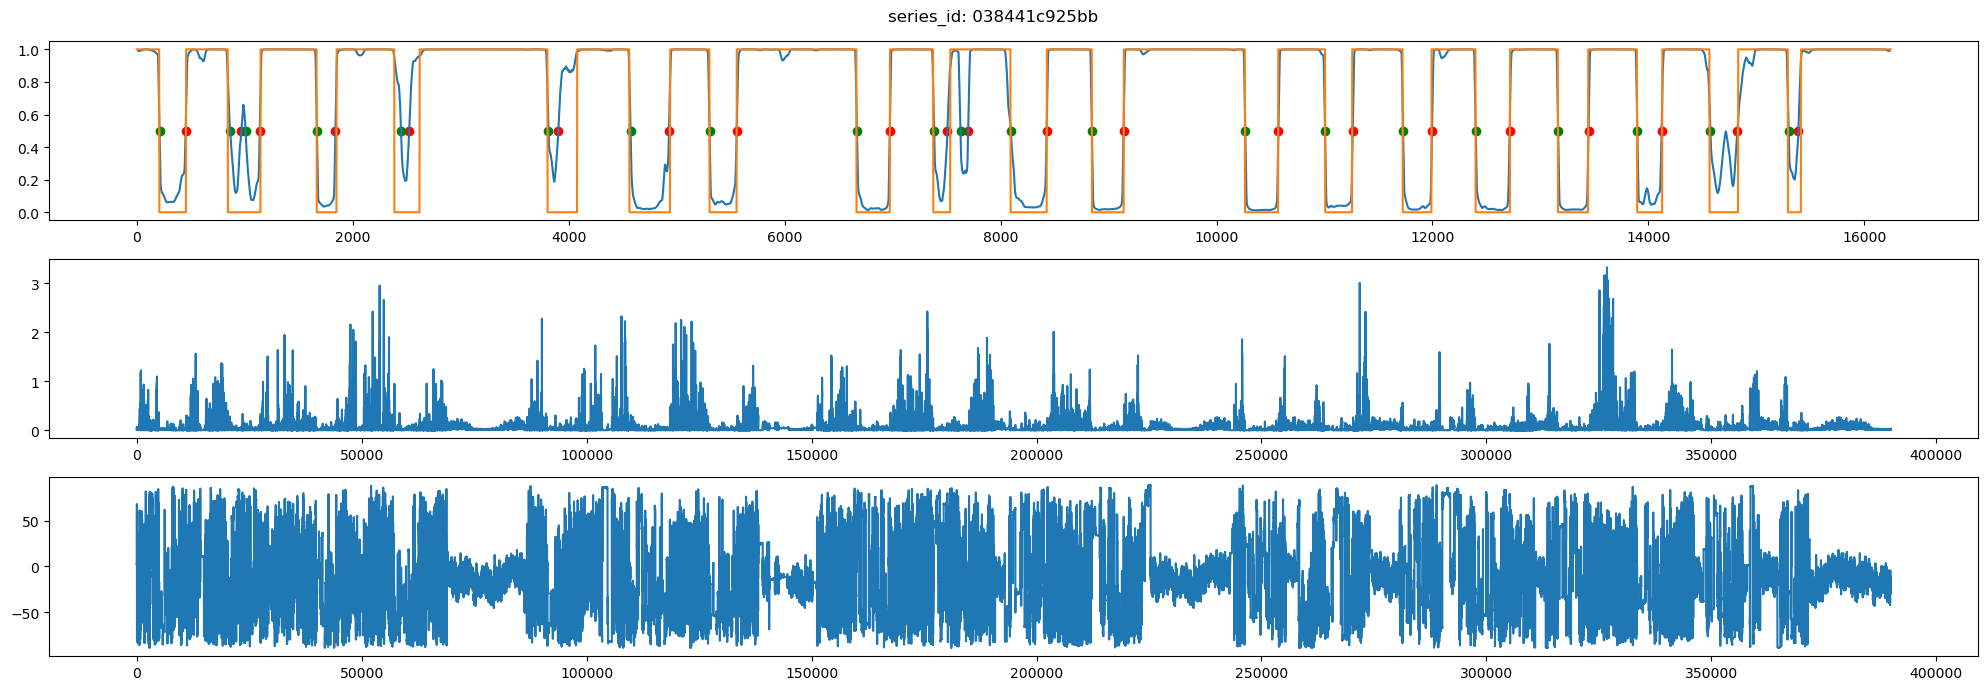

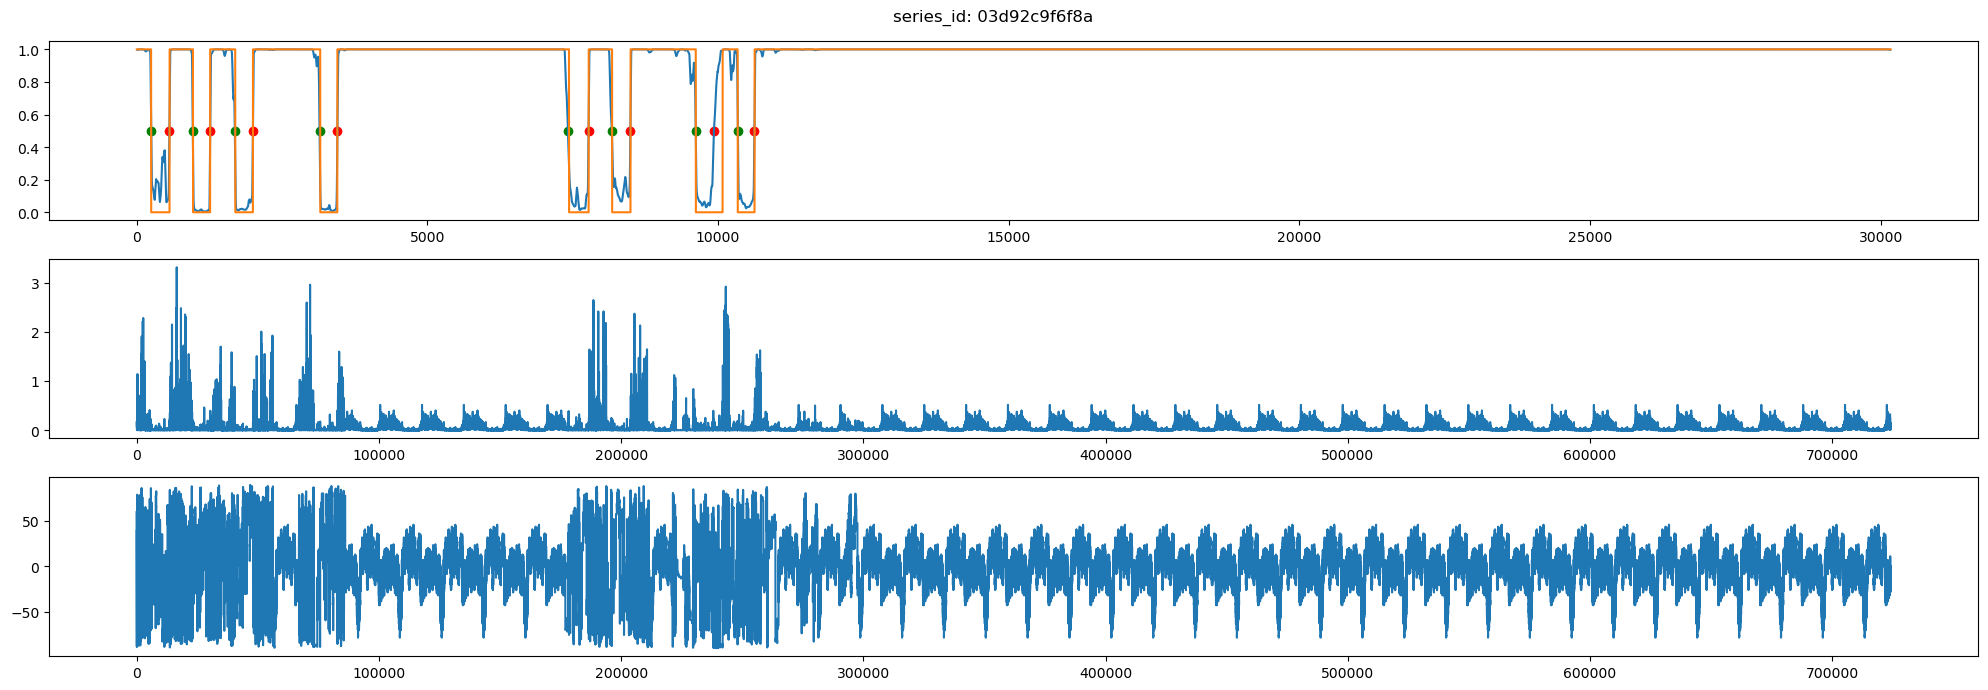

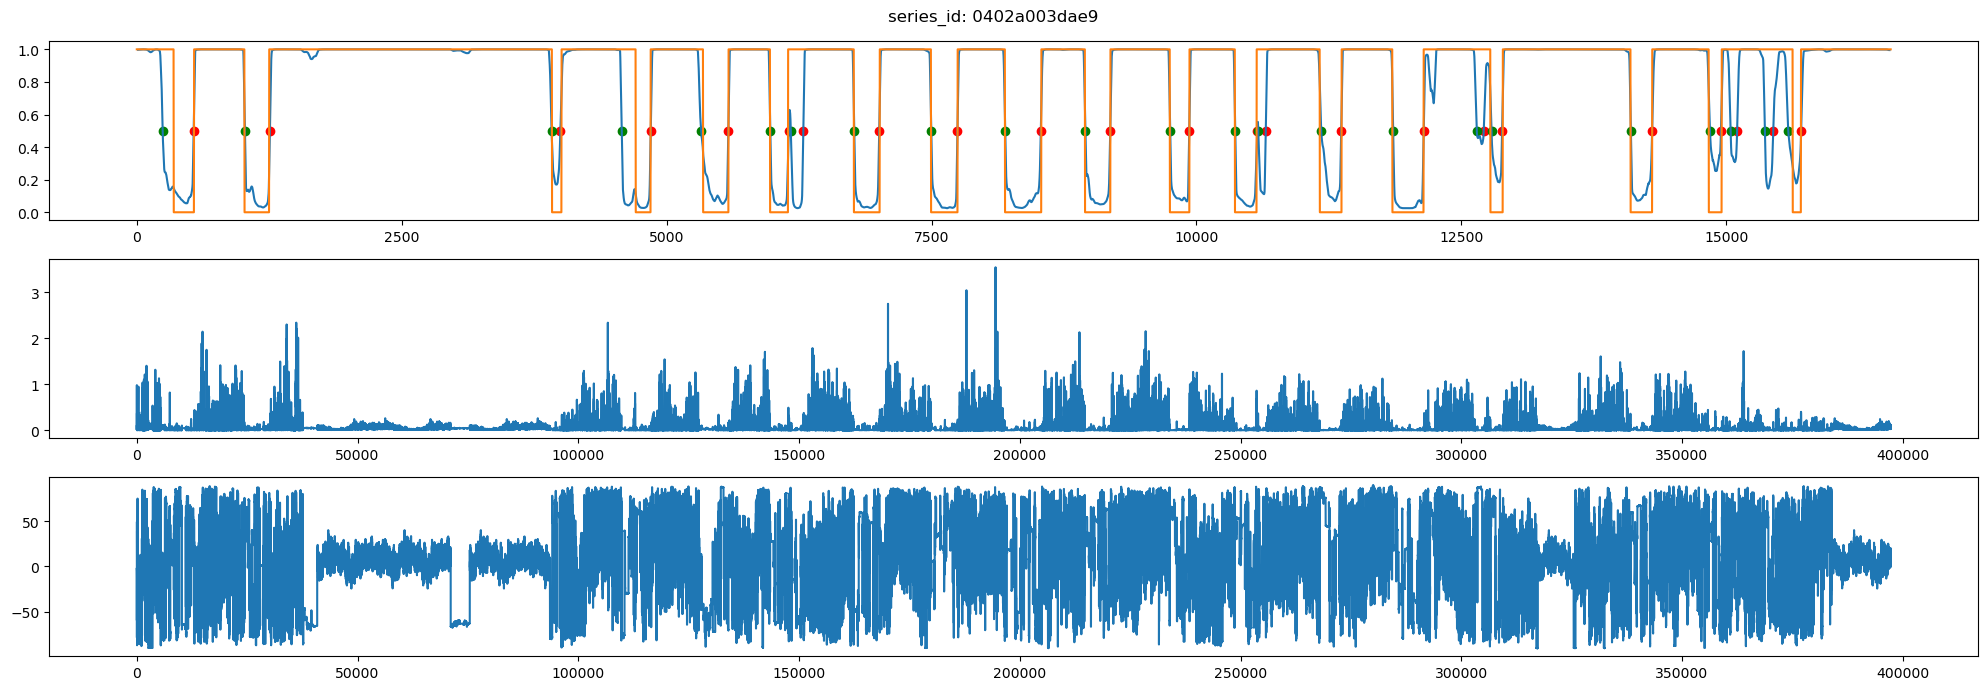

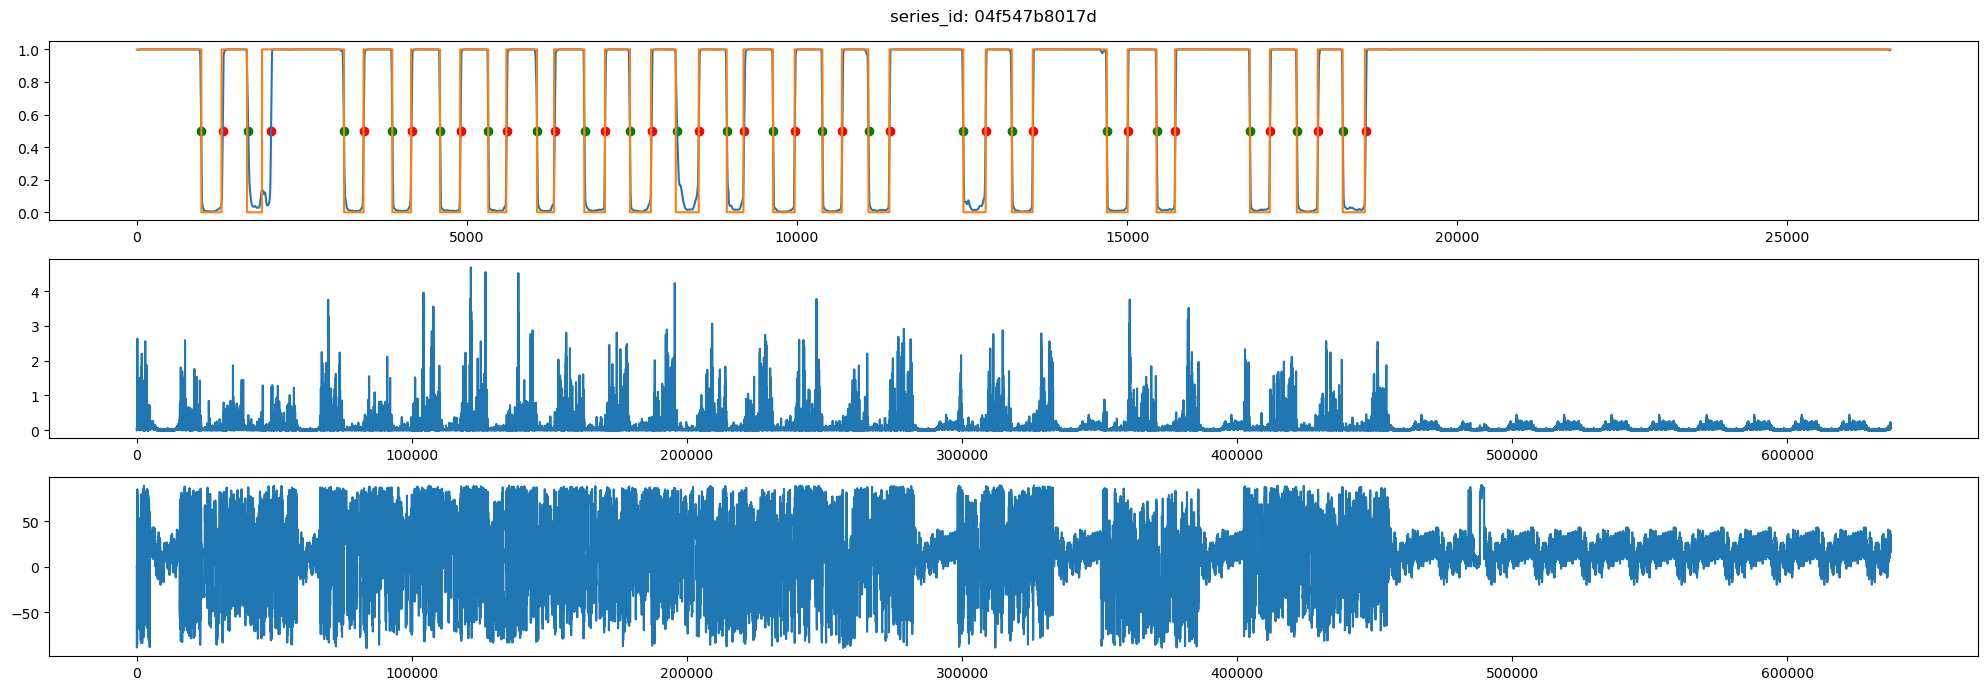

,series_id,step,event,score
0,038441c925bb,10847,wakeup,1
1,038441c925bb,23255,wakeup,1
2,038441c925bb,27335,wakeup,1
3,038441c925bb,44159,wakeup,1
4,038441c925bb,60551,wakeup,1


In [9]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(24, center=True).mean()
    wakeup_index = np.array([i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(oof)
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.4325


event   tolerance
onset   12           0.005580
        36           0.053875
        60           0.154705
        90           0.300230
        120          0.444478
        150          0.517770
        180          0.575496
        240          0.639151
        300          0.682449
        360          0.709851
wakeup  12           0.016942
        36           0.127478
        60           0.258702
        90           0.380888
        120          0.483383
        150          0.549843
        180          0.603042
        240          0.675706
        300          0.720201
        360          0.749727
dtype: float64

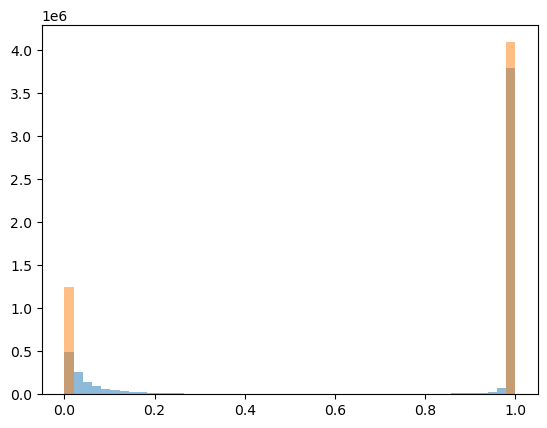

In [10]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [11]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9391
next_cand_size: 11397396.0


In [12]:
import pickle

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)